### VENTAS

In [2]:
import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from git import Repo
from github import Github

In [164]:
url = 'https://www.sharwinn.com/wp-json/wc/v3/orders'                   # url
params = {
    'consumer_key': 'ck_e88ed88e0a1684cd729a37dee41c2a3cb503b0ec',      # CK
    'consumer_secret': 'cs_0cc67c5057e588a91ba99b38271729baeb83dc56',   # CS
    'per_page': 100,                                                    # número de pedidos por página
    'meta_data': ['_yith_pos_cashier', '[P] _alg_wc_cog_cost']     # Metadata
}
orders = []                                                             # lista para almacenar los pedidos
#response = requests.get(url, params=params)                             # Consulta para extraer el número de páginas
#npages=round(int(response.headers['X-WP-Total'])/100)+1                 # Conseguimos el número de Páginas

for page in range(1, 2):                                           # Ciclo For para extraer la data
    params['page'] = page
    response = requests.get(url, params=params)
    orders += response.json()

df_agrupada = pd.DataFrame(orders)                                               # Convertimos en DataFrame

df_expanded = df_agrupada.explode('line_items')
df_expanded = pd.concat([df_expanded.drop(['line_items'], axis=1), df_expanded['line_items'].apply(pd.Series)], axis=1)

# Expande los datos de la columna 'yith_pos_data' utilizando json_normalize
df_normalized = json_normalize(df_expanded['yith_pos_data'])
# Concatenar
df_expanded1=df_expanded.copy()
df_normalized1=df_normalized.copy()
df_expanded1 = df_expanded1.reset_index()
df_normalized1 = df_normalized1.reset_index()
df_combined = pd.concat([df_expanded1, df_normalized1], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_7980\2088366173.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_normalized = json_normalize(df_expanded['yith_pos_data'])


In [165]:
# Selección de Columnas útiles
ventas = df_combined.loc[:, ['id', 'status', 'date_created','payment_method_title',
                            'name', 'product_id', 'variation_id', 'quantity',
                            'subtotal', 'subtotal_tax', 'price', 'register_name']]
# Elimina columna redundante en el nombre
ventas.columns.values[0] = 'id_order'
ventas = ventas.drop(ventas.columns[1], axis=1)

In [166]:
# Cambio de tipo de datos en las columnas
ventas['date_created'] = pd.to_datetime(ventas['date_created'])
# Formatear la columna date_created en YYYY-MM-DD
ventas['date_created'] = ventas['date_created'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
ventas['date_created'] = pd.to_datetime(ventas['date_created'])

In [167]:
# Cambio de variables INT
ventas['id_order'] = ventas['id_order'].astype(int)
ventas['product_id'] = ventas['product_id'].astype(int)
ventas['variation_id'] = ventas['variation_id'].astype(int)
ventas['quantity'] = ventas['quantity'].astype(int)
# Cambio de variables FLOAT
ventas['subtotal'] = ventas['subtotal'].astype(float)
ventas['subtotal_tax'] = ventas['subtotal_tax'].astype(float)
ventas['price'] = ventas['price'].astype(float)
# Cambio de variables STRING
ventas['status'] = ventas['status'].astype(str)
ventas['status'] = ventas['status'].astype(str)
ventas['name'] = ventas['name'].astype(str)
ventas['register_name'] = ventas['register_name'].astype(str)

In [168]:
# Levantamiento de ventas
ventas_mkp = ventas[ventas['register_name'].str.contains('Caja 2')]

### PRODUCTOS

In [169]:
# Importación de Productos
url = 'https://www.sharwinn.com/wp-json/wc/v3/products'                 # url
params = {
    'consumer_key': 'ck_e88ed88e0a1684cd729a37dee41c2a3cb503b0ec',      # CK
    'consumer_secret': 'cs_0cc67c5057e588a91ba99b38271729baeb83dc56',   # CS
    'per_page': 100,                                                    # número de pedidos por página
}
products = []                                                             # lista para almacenar los pedidos
response = requests.get(url, params=params)                             # Consulta para extraer el número de páginas
npages=round(int(response.headers['X-WP-Total'])/100)+2                 # Conseguimos el número de Páginas

for page in range(1, npages):                                           # Ciclo For para extraer la data
    params['page'] = page
    response = requests.get(url, params=params)
    products += response.json()

p_agrupada = pd.DataFrame(products)                                     # Convertimos en DataFrame

KeyboardInterrupt: 

In [ ]:
products=p_agrupada.copy()

In [ ]:
# Selección de productos a Trabajar para Productos
products.rename(columns={'id': 'product_id'}, inplace=True)
productos = products.loc[:, ['product_id', 'name', 'date_created', 'type',
                            'status', 'sku', 'price', 'regular_price','total_sales',
                            'stock_quantity','categories']]

In [ ]:
# Convertir la columna date_created en un objeto datetime
productos['date_created'] = pd.to_datetime(productos['date_created'])
# Formatear la columna date_created en YYYY-MM-DD
productos['date_created'] = productos['date_created'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
# Convertir la columna date_created en un objeto datetime
productos['date_created'] = pd.to_datetime(productos['date_created'])

In [ ]:
# Cambio de variables INT
productos['product_id'] = productos['product_id'].fillna(0).astype(int)
productos['stock_quantity'] = productos['stock_quantity'].fillna(0).astype(int)
productos['total_sales'] = productos['total_sales'].fillna(0).astype(int)

In [ ]:
# Cambio de variables FLOAT
productos['price'] = productos['price'].replace('', 0.0).fillna(0.0).astype(float)
productos['regular_price'] = productos['regular_price'].replace('','nan').fillna(productos['price']).astype(float)

In [ ]:
# Cambio de variables STR
productos['name'] = productos['name'].fillna('').astype(str)
productos['type'] = productos['type'].fillna('').astype(str)
productos['status'] = productos['status'].fillna('').astype(str)
productos['sku'] = productos['sku'].fillna('').astype(str)

### VISUALIZACIONES

    Rotación

        Primera Venta

In [ ]:
# Primera venta desde su lanzamiento
primer_venta=ventas_mkp.copy()
creacion_productos=productos.copy()
# Se agrupa por id_producto y se aplica la función de agregación min() a la columna venta
fecha_primera_venta= primer_venta.groupby('product_id')['date_created'].agg(min).reset_index(name='Fecha_Primera_Venta')
fecha_Creacion= creacion_productos.groupby('product_id')['date_created'].agg(min).reset_index(name='Fecha_Creacion_producto')
# Unir los dataframe resultantes
primer_venta_fechas=pd.merge(fecha_primera_venta, fecha_Creacion, on='product_id')

In [ ]:
# Calculamos la diferencias de días
primer_venta_fechas['diferencia_en_dias'] = (primer_venta_fechas['Fecha_Primera_Venta'] - primer_venta_fechas['Fecha_Creacion_producto']).dt.days
primer_venta_fechas_sorted=primer_venta_fechas.sort_values('diferencia_en_dias', ascending=True)
# Agregamos el Nombre del producto
primer_venta_fechas_nombre = primer_venta.loc[:, ['product_id', 'name']]
df_sin_duplicados = primer_venta_fechas_nombre.drop_duplicates(subset=['product_id'])
# Juntamos el dataframe
primer_venta_completo=pd.merge(primer_venta_fechas_sorted, df_sin_duplicados, on='product_id')

In [ ]:
# Generación de DataFrame "Lista Completa" Por Días
diferencia_en_dias_rango=3
rotacion_primera_venta = primer_venta_completo.loc[:, ['product_id', 'name', 'Fecha_Creacion_producto', 'diferencia_en_dias']]
rotacion_primera_venta.loc[rotacion_primera_venta['diferencia_en_dias'] <=diferencia_en_dias_rango]

,product_id,name,Fecha_Creacion_producto,diferencia_en_dias
0,46249,Protector impermeable para celular,2023-03-14,2


In [ ]:
# Generación de DataFrame "Lista Completa" Por Fecha
Fecha_Creacion_producto_rango='2023-03-01'
rotacion_primera_venta = primer_venta_completo.loc[:, ['product_id', 'name', 'Fecha_Creacion_producto', 'diferencia_en_dias']]
rotacion_primera_venta.loc[rotacion_primera_venta['Fecha_Creacion_producto'] >=Fecha_Creacion_producto_rango]

,product_id,name,Fecha_Creacion_producto,diferencia_en_dias
0,46249,Protector impermeable para celular,2023-03-14,2
1,46072,Collares amor de mamá -Acero - Docena,2023-03-06,10
2,46056,Termo conservador con 2 tazas -500ml,2023-03-06,11


In [ ]:
# Graficar por Precio de venta
venta_promedio_id = ventas_mkp.groupby('product_id')['subtotal'].mean().reset_index(name='precio_promedio')
venta_promedio=pd.merge(rotacion_primera_venta, venta_promedio_id, on='product_id')
venta_promedio_precio = venta_promedio.loc[:, ['product_id', 'diferencia_en_dias','precio_promedio']]

,product_id,diferencia_en_dias,precio_promedio
0,46249,2,9.743333


Text(0.5, 1.0, 'Cantidad de ordenes x Precio')

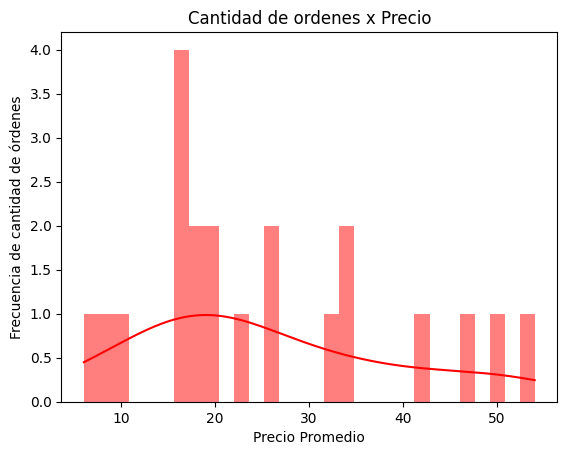

In [ ]:
dias_limite_LI=venta_promedio_precio['diferencia_en_dias'].min()
dias_limite_LS=venta_promedio_precio['diferencia_en_dias'].max()
dias_limite=100
fig=plt.figure()
sns.histplot(data=venta_promedio_precio[venta_promedio_precio['diferencia_en_dias']<dias_limite], x="precio_promedio", color='red', bins=30, kde=True, linewidth=0)
plt.xlabel('Precio Promedio')
plt.ylabel('Frecuencia de cantidad de órdenes')
plt.title('Cantidad de ordenes x Precio')

Text(0.5, 1.0, 'Cantidad de ordenes x Días de la Primera')

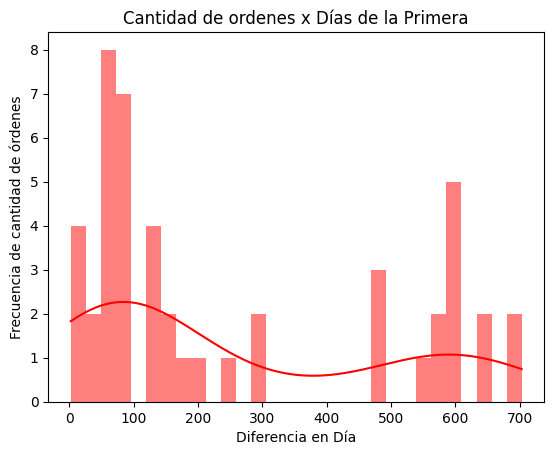

In [ ]:
precio_limite_LI=venta_promedio_precio['precio_promedio'].min()
precio_limite_LS=venta_promedio_precio['precio_promedio'].max()
precio_limite=100
fig=plt.figure()
sns.histplot(data=venta_promedio_precio[venta_promedio_precio['precio_promedio']<precio_limite], x="diferencia_en_dias", color='red', bins=30, kde=True, linewidth=0)
plt.xlabel('Diferencia en Día')
plt.ylabel('Frecuencia de cantidad de órdenes')
plt.title('Cantidad de ordenes x Días de la Primera')

        Indicadores Semanales (IS)

In [ ]:
#Generar Dataframe con la información importante
flujo_semanal=ventas_mkp.copy()
df_semanal = flujo_semanal.loc[:, ['id_order','date_created', 'quantity', 'price', 'subtotal']]
df_semanal['nombre_dia_semana'] = df_semanal['date_created'].dt.day_name()
df_semanal['numero_mes'] = df_semanal['date_created'].dt.month
df_semanal['numero_ano'] = df_semanal['date_created'].dt.year

In [ ]:
# PARETO POR CANTIDAD
# Filtrar por cantidad
filtro_mes_IS= 3
filtro_ano_IS=2023

# Agrupar los datos por día de la semana y sumar las ventas
df_semanal_mes_filtrado = df_semanal[(df_semanal['numero_mes'] == 3) & (df_semanal['numero_ano'] == 2023)]
ventas_por_dia = df_semanal_mes_filtrado.groupby('nombre_dia_semana')['quantity'].sum().reset_index(name='cantidad_productos_dia_semana')

# Ordenar los datos por frecuencia
ventas_por_dia = ventas_por_dia.sort_values('cantidad_productos_dia_semana', ascending=False)

# Calcular la frecuencia acumulada y el porcentaje acumulado
ventas_por_dia['Frecuencia_acumulada'] = ventas_por_dia['cantidad_productos_dia_semana'].cumsum()
ventas_por_dia['Porcentaje_acumulado'] = 100 * ventas_por_dia['Frecuencia_acumulada'] / ventas_por_dia['cantidad_productos_dia_semana'].sum()

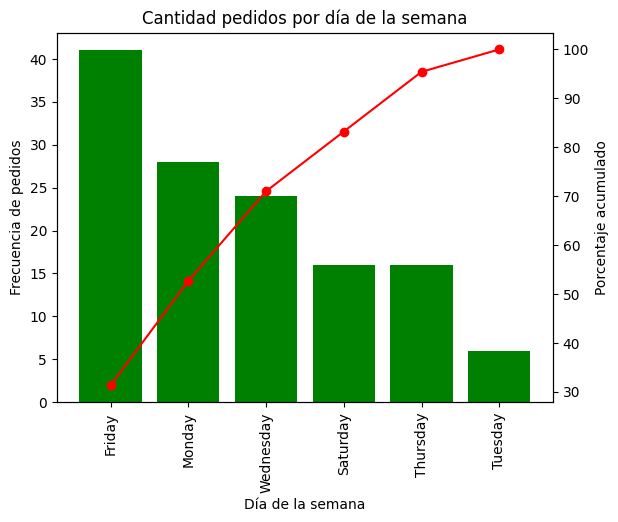

In [ ]:
# Crear el gráfico de barras
fig, ax = plt.subplots()
ax.bar(ventas_por_dia['nombre_dia_semana'], ventas_por_dia['cantidad_productos_dia_semana'], color='green')

# Agregar la línea de porcentaje acumulado
ax2 = ax.twinx()
ax2.plot(ventas_por_dia['nombre_dia_semana'], ventas_por_dia['Porcentaje_acumulado'], color='red', marker='o')
ax2.grid(False)

# Personalizar el gráfico
ax.set_xlabel('Día de la semana')
ax.set_ylabel('Frecuencia de pedidos')
ax2.set_ylabel('Porcentaje acumulado')
ax.tick_params(axis='x', rotation=90)
plt.title('Cantidad pedidos por día de la semana')
plt.show()

In [ ]:
# PARETO POR MONTOS
# Filtrar por cantidad
filtro_mes_IS= 3
filtro_ano_IS=2023

# Agrupar los datos por día de la semana y sumar las ventas
df_semanal_mes_filtrado = df_semanal[(df_semanal['numero_mes'] == 3) & (df_semanal['numero_ano'] == 2023)]
ventas_por_dia = df_semanal_mes_filtrado.groupby('nombre_dia_semana')['subtotal'].sum().reset_index(name='venta_dia_semana')

# Ordenar los datos por frecuencia
ventas_por_dia = ventas_por_dia.sort_values('venta_dia_semana', ascending=False)

# Calcular la frecuencia acumulada y el porcentaje acumulado
ventas_por_dia['Frecuencia_acumulada'] = ventas_por_dia['venta_dia_semana'].cumsum()
ventas_por_dia['Porcentaje_acumulado'] = 100 * ventas_por_dia['Frecuencia_acumulada'] / ventas_por_dia['venta_dia_semana'].sum()

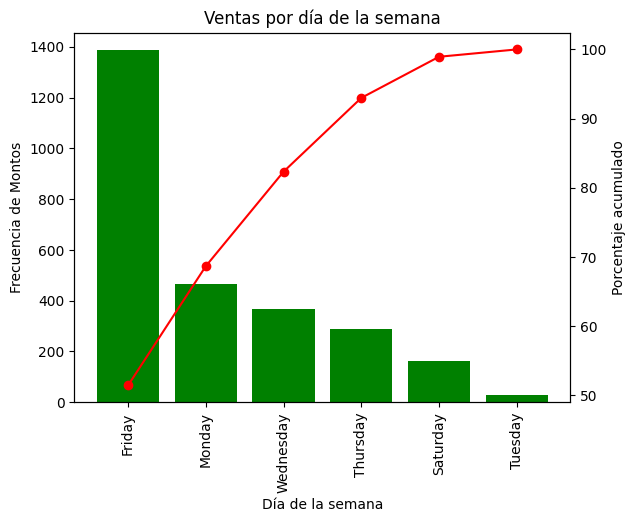

In [ ]:
# Crear el gráfico de barras
fig, ax = plt.subplots()
ax.bar(ventas_por_dia['nombre_dia_semana'], ventas_por_dia['venta_dia_semana'], color='green')

# Agregar la línea de porcentaje acumulado
ax2 = ax.twinx()
ax2.plot(ventas_por_dia['nombre_dia_semana'], ventas_por_dia['Porcentaje_acumulado'], color='red', marker='o')
ax2.grid(False)

# Personalizar el gráfico
ax.set_xlabel('Día de la semana')
ax.set_ylabel('Frecuencia de Montos')
ax2.set_ylabel('Porcentaje acumulado')
ax.tick_params(axis='x', rotation=90)
plt.title('Ventas por día de la semana')
plt.show()

In [ ]:
# PRODUCTOS POPULARES
filtro_populares_cantidad=5
# Copiar
ventas_populares=ventas_mkp.copy()
productos_populares=productos.copy()
# Extraer data
ventas = ventas_populares.groupby('product_id')['quantity'].sum().reset_index(name='cantidad_total')    # Extraemos la cantidad total de ventas
nombres = productos_populares.loc[:, ['product_id','name']]                                             # Extraer nombres
valores_populares=pd.merge(ventas, nombres, on='product_id')                                            # Unimos
populares = valores_populares.sort_values(by='cantidad_total', ascending=False)                         # Ordenar
df_populares = populares.loc[:, ['name','cantidad_total']]                                              # Seleccionamos columnas


In [ ]:
df_populares.head(filtro_populares_cantidad)

,name,cantidad_total
20,Papel Tapiz 3mm -Blanco,20
34,Molde para Helados,12
15,Soporte de Celular con Espejo - 2 en 1,7
35,Pack de Tomatodo osos escandalosos,6
47,Protector impermeable para celular,5


Analizar la frecuencia de compra de los clientes y determinar cuántos clientes han realizado más de una compra en tu tienda.
Analizar las tendencias de ventas en función del tiempo y determinar cuándo se producen los picos de ventas.
Analizar las ventas por categoría de producto y determinar cuáles son las categorías más populares.
Analizar los productos más vendidos y determinar cuáles son los productos más populares en tu tienda.

In [2]:
ventas_mkp = pd.read_csv('ventas_mkp.csv')
productos = pd.read_csv('productos.csv')

In [5]:
# Convertir la columna date_created en un objeto datetime
productos['date_created'] = pd.to_datetime(productos['date_created'])

# Cambio de variables INT
productos['product_id'] = productos['product_id'].fillna(0).astype(int)
productos['stock_quantity'] = productos['stock_quantity'].fillna(0).astype(int)
productos['total_sales'] = productos['total_sales'].fillna(0).astype(int)

# Cambio de variables FLOAT
productos['price'] = productos['price'].replace('', 0.0).fillna(0.0).astype(float)
productos['regular_price'] = productos['regular_price'].replace('','nan').fillna(productos['price']).astype(float)

# Cambio de variables STR
productos['name'] = productos['name'].fillna('').astype(str)
productos['type'] = productos['type'].fillna('').astype(str)
productos['status'] = productos['status'].fillna('').astype(str)
productos['sku'] = productos['sku'].fillna('').astype(str)